In [1]:
import lecroy
import rigol
import numpy as np
from matplotlib import pyplot as plt
from my_utils import *
from sigproc_kit import *
import time

LECROY,WR620ZI,LCRY2805N57162,8.5.1
Rigol Technologies,DG4202,DG4E212801262,00.01.14


In [2]:
#%matplotlib notebook

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
plt.rcParams["figure.figsize"] = (8,5)

clear_data_dir()

In [3]:
##################################################
##                init PASTTREC                 ##
##################################################

import pasttrec_ctrl as ptc

channel = 7
my_baseline = 6

ptc.init_board("0001",1,15,4,127)
#ptc.init_board("0001",1,20,2,127) # alternative setting, pkt 20, gain 2, does the model still hold?
#ptc.init_board("0001",1,10,1,127) # alternative setting
ptc.set_baseline("0001",1,channel,my_baseline) 
# zero V baseline for my channel relative to thr=0 - > scan said baseline at 5



In [4]:
##################################################
##              program RIGOL AWG               ##
##################################################


awg_samples = 2**12
awg_period = 500e-9
awg_time = np.linspace(0,awg_period,awg_samples)

injection_resistor = 32.8e3

#test_curr = -50e-6

#test_amp = test_curr*injection_resistor



#test_i = test_curr*(awg_time>50e-9)*(awg_time<350e-9)

#sigma = 1e-9
#test_i  = test_curr*gauss(awg_time,mu=100e-9,sigma=sigma)*sigma

test_charge = 10e-15
test_i = - test_charge * gauss(awg_time,mu=100e-9,sigma=2.5e-9)

test_curr = np.max(abs(test_i))
test_amp  = test_curr * injection_resistor

#test_i =  test_curr*(awg_time>50e-9)*(awg_time<55e-9)

y1 = test_i * injection_resistor
y2 = y1

print("test current   = {:e} A".format(test_curr))
print("test amplitude = {:f} V".format(test_amp))

rigol.set_waveform(1,awg_time,y1)
rigol.set_waveform(2,awg_time,y2)


test current   = 1.595769e-06 A
test amplitude = 0.052341 V


saving to /workdir/jupyter/PASTTREC/PASTTREC_threshold_scan_SE_LVDS_data/000.svg
saving to /workdir/jupyter/PASTTREC/PASTTREC_threshold_scan_SE_LVDS_data/000.pickle


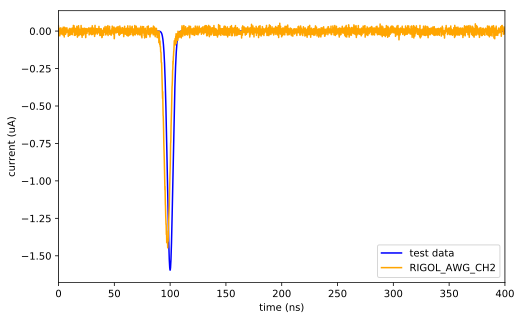

saving to /workdir/jupyter/PASTTREC/PASTTREC_threshold_scan_SE_LVDS_data/001.svg
saving to /workdir/jupyter/PASTTREC/PASTTREC_threshold_scan_SE_LVDS_data/001.pickle


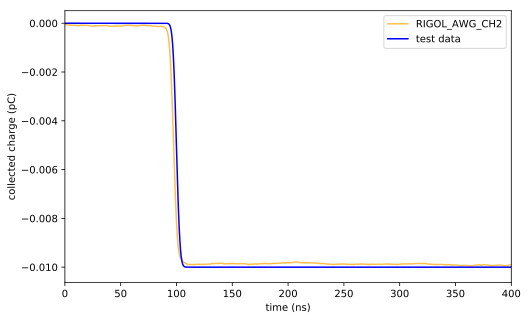

In [5]:
##################################################
##           configure LeCroy Scope             ##
##################################################

lecroy.clear_all()
lecroy.set_tdiv(100e-9)

# access scope sources by labels
s = {
    "RIGOL_AWG_CH2"    :"C1", # set to 50R DC
    "PASTTREC_LVDS"    :"C4", # use LeCroy ZD1500 differential probe
    "PASTTREC_analog"  :"C3"  # set to 50R DC
}

# set vertical amplifications and offsets
lecroy.set_vdiv(              s["PASTTREC_LVDS"],200e-3)
lecroy.set_voffset(           s["PASTTREC_LVDS"],-1200e-3 ) ### if ZS1500 is used instead diff probe

lecroy.set_vdiv(              s["RIGOL_AWG_CH2"],abs(test_amp/4.*1.2))

#lecroy.set_vdiv(              s["PASTTREC_analog"],abs(test_amp *1e12)/2.*1.2 )
#lecroy.set_voffset(           s["PASTTREC_analog"],-1000e-3 )


# access scope measurements by labels
m = {
    "PASTTREC_t1"  : "p3",
    "PASTTREC_tot" : "p4"
}

# TDC measurements for differential probe at 100R terminated PASTTREC LVDS output
lecroy.setup_measurement(m["PASTTREC_t1"] ,s["PASTTREC_LVDS"],"delay")
lecroy.setup_measurement(m["PASTTREC_tot"],s["PASTTREC_LVDS"],"widthn")


# access scope trigger channels by labels

t = {
    "RIGOL_AWG_SYNC1" : "D9",
    "RIGOL_AWG_SYNC2" : "D10"
}

##################################################
##             measure AWG Waveform             ##
##################################################

lecroy.set_trig_source(t["RIGOL_AWG_SYNC2"])

time, wfm = lecroy.capture_waveforms([
    s["RIGOL_AWG_CH2"]
])

time_ns     = time*1e9
awg_time_ns = awg_time*1e9


meas_i = wfm[s["RIGOL_AWG_CH2"]] / injection_resistor

meas_i = remove_baseline(meas_i)

plt.plot(awg_time_ns, test_i *1e6,"b" ,label="test data")
plt.plot(time_ns,     meas_i *1e6,"orange" ,label="RIGOL_AWG_CH2")


plt.legend()
plt.xlabel("time (ns)")
plt.ylabel("current (uA)")
plt.xlim(0,400)
show(plt)

##################################################
##          see if charge is conserved          ##
##################################################

plt.plot(time_ns,     integrate_dt(time,     meas_i)*1e12 ,"orange",alpha=0.7 ,label="RIGOL_AWG_CH2")
plt.plot(awg_time_ns, integrate_dt(awg_time, test_i)*1e12 ,"b" ,label="test data")

plt.legend()
plt.xlabel("time (ns)")
plt.ylabel("collected charge (pC)")
plt.xlim(0,400)
show(plt)

saving to /workdir/jupyter/PASTTREC/PASTTREC_threshold_scan_SE_LVDS_data/002.svg
saving to /workdir/jupyter/PASTTREC/PASTTREC_threshold_scan_SE_LVDS_data/002.pickle


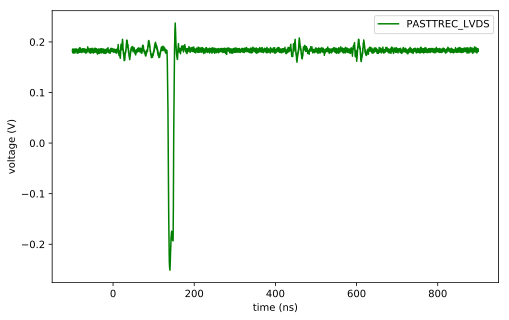

saving to /workdir/jupyter/PASTTREC/PASTTREC_threshold_scan_SE_LVDS_data/003.svg
saving to /workdir/jupyter/PASTTREC/PASTTREC_threshold_scan_SE_LVDS_data/003.pickle


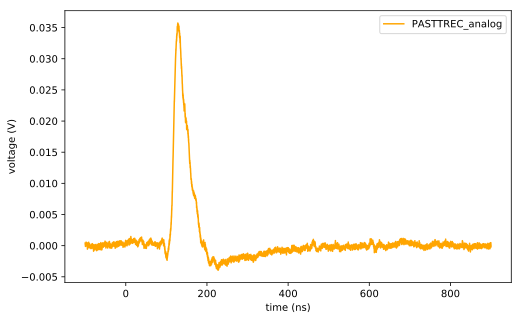

saving to /workdir/jupyter/PASTTREC/PASTTREC_threshold_scan_SE_LVDS_data/004.svg
saving to /workdir/jupyter/PASTTREC/PASTTREC_threshold_scan_SE_LVDS_data/004.pickle


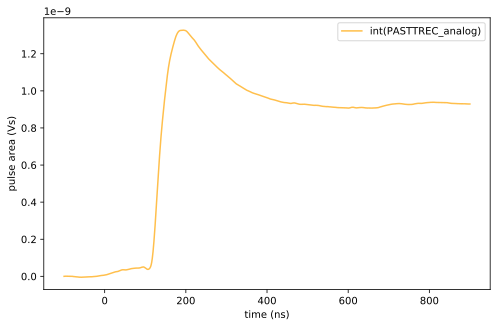

In [6]:
##################################################
##      capture ana waveform and LVDS out       ##
##################################################

lecroy.set_trig_source(t["RIGOL_AWG_SYNC1"])


ptc.set_threshold("0001",1,0,16) # tdc, conn, chip thresh

#lecroy.set_vdiv(              s["PASTTREC_analog"],100e-3 )
#lecroy.set_voffset(           s["PASTTREC_analog"],-1000e-3 )

lecroy.set_vdiv(              s["PASTTREC_analog"],200e-3*test_charge*1e12*8)
lecroy.set_voffset(           s["PASTTREC_analog"],-800e-3 )

time, wfm = lecroy.capture_waveforms([
    s["PASTTREC_LVDS"],
    s["PASTTREC_analog"]
  ],
    #average=100
    average=10
)

time_ns = time*1e9

# remove analog signal baseline, calculate bl from the first 10% of the sample
pt_ana = wfm[s["PASTTREC_analog"]]
pt_ana = remove_baseline(pt_ana,fraction=0.08)

plt.plot(time_ns,wfm[s["PASTTREC_LVDS"]] ,"g" ,label="PASTTREC_LVDS")
plt.legend()
plt.xlabel("time (ns)")
plt.ylabel("voltage (V)")
show(plt)

plt.plot(time_ns,pt_ana,"orange",label="PASTTREC_analog")
plt.legend()
plt.xlabel("time (ns)")
plt.ylabel("voltage (V)")
show(plt)

##################################################
##                 Output integral              ##
##################################################

plt.plot(time_ns,     integrate_dt(time,     pt_ana) ,"orange",alpha=0.7 ,label="int(PASTTREC_analog)")


plt.legend()
plt.xlabel("time (ns)")
plt.ylabel("pulse area (Vs)")
#plt.xlim(0,400)
show(plt)

saving to /workdir/jupyter/PASTTREC/PASTTREC_threshold_scan_SE_LVDS_data/005.svg
saving to /workdir/jupyter/PASTTREC/PASTTREC_threshold_scan_SE_LVDS_data/005.pickle


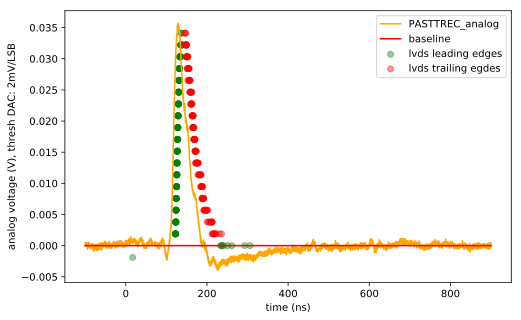

In [7]:
##################################################
##           PASTTREC threshold scan            ##
##################################################




lecroy.set_trig_source(t["RIGOL_AWG_SYNC1"])


thresholds = range(0,32,1)
baselines = range(-15,16,1)

n=10

meta_stats = {}


c = 0
for i in thresholds:
  ptc.set_threshold("0001",1,0,i) # tdc, conn, chip thresh
  meta_stats[i] = lecroy.measure_statistics(["P3","P4"],n)
  #time.sleep(0.1)
  c += 1


ptc.set_threshold("0001",1,0,0) # tdc, conn, chip thresh
for j in baselines:
  ptc.set_baseline("0001",1,channel,j) 
  meta_stats[my_baseline-j] = lecroy.measure_statistics(["P3","P4"],n)
  #time.sleep(0.1)
  c += 1



c = 0
my_ysteps = list(meta_stats.keys())
my_ysteps.sort()

scat_y          = np.zeros(len(my_ysteps)*n)
scat_x_leading  = np.zeros(len(my_ysteps)*n)
scat_x_trailing = np.zeros(len(my_ysteps)*n)

for i in my_ysteps:
  for j in range(0,n):
    scat_y[c] = i
    xl = meta_stats[i]["P3"][j]
    xt = meta_stats[i]["P3"][j] + meta_stats[i]["P4"][j]
    scat_x_leading[c] = xl # median filtered
    scat_x_trailing[c] = xt # median filtered
    c+=1


scat_x_leading *= 1e9
scat_x_trailing *= 1e9

scat_y *= 0.001895


plt.plot(time_ns,pt_ana,"orange",label="PASTTREC_analog")
plt.plot(time_ns,np.zeros(len(time_ns)),"red",label="baseline")
plt.scatter(scat_x_leading,scat_y  ,label="lvds leading edges", c="g",alpha=0.4)
plt.scatter(scat_x_trailing,scat_y ,label="lvds trailing egdes",c="r",alpha=0.4)
#plt.plot(scx,ana_wav,label="analog waveform")
plt.xlabel("time (ns)")
plt.ylabel("analog voltage (V), thresh DAC: 2mV/LSB")
plt.legend()
show(plt)


saving to /workdir/jupyter/PASTTREC/PASTTREC_threshold_scan_SE_LVDS_data/006.svg
saving to /workdir/jupyter/PASTTREC/PASTTREC_threshold_scan_SE_LVDS_data/006.pickle


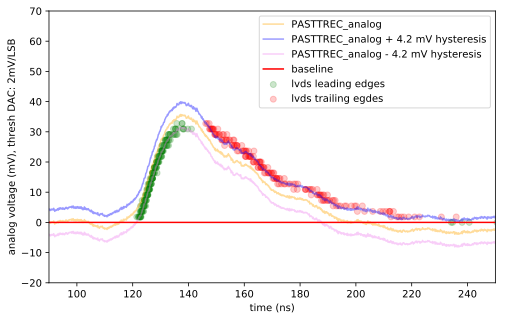

In [8]:




ana_offset_ns=9
ana_offset_mV=4.2

plt.plot(time_ns+ana_offset_ns,1e3*pt_ana,"orange",label="PASTTREC_analog",alpha=0.4)
plt.plot(time_ns+ana_offset_ns,1e3*(pt_ana+ana_offset_mV*1e-3),"blue",label="PASTTREC_analog + 4.2 mV hysteresis",alpha=0.4)
plt.plot(time_ns+ana_offset_ns,1e3*(pt_ana-ana_offset_mV*1e-3),"violet",label="PASTTREC_analog - 4.2 mV hysteresis",alpha=0.4)
plt.plot(time_ns,np.zeros(len(time_ns)),"red",label="baseline")
plt.scatter(scat_x_leading,0.96*1e3*scat_y  ,label="lvds leading edges", c="g",alpha=0.2)
plt.scatter(scat_x_trailing,0.96e3*scat_y ,label="lvds trailing egdes",c="r",alpha=0.2)
plt.xlabel("time (ns)")
plt.ylabel("analog voltage (mV), thresh DAC: 2mV/LSB")
plt.legend()
plt.xlim(90,250)
plt.ylim(-20,70)
show(plt)